# Optimizer
Gets data and uses it to optimize a method (imported from method.py) using a loss function and tests it against unseen data


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sns as sns
import torch
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Import data

In [3]:
### Load the data
seed = 1
data_path = 'data/output/data_complete_grouped_2022-06-22.csv'
df = pd.read_csv(data_path)

# Scale Data

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
M = scaler.fit_transform(df.drop(columns=['dataset']))
#M = df.drop(columns=['dataset']).to_numpy()
#y = M[:,-1]
y = df['Thermal feeling (global)'].to_numpy() + 1
X = M[:,:-1]
#X = M

[-0.15073885  0.66329091  0.12524925 -0.0826543  -0.1967491   0.00250448
 -0.06263211 -0.02741825  0.05681769 -0.04580313  0.0520164 ]


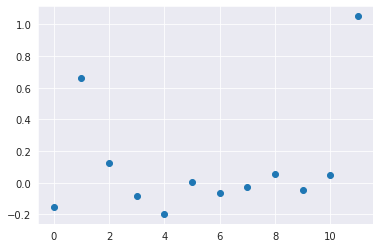

In [5]:
# Quick analysis of linear relationship of data
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X, y)

# display coefficients
print(regressor.coef_)
plt.scatter(np.arange(len(regressor.coef_)+1),regressor.coef_.tolist()+[regressor.intercept_])
plt.show()

# Train

In [6]:
from sklearn.utils import class_weight

class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
class_weights=torch.tensor(class_weights,dtype=torch.float)
class_weights

tensor([1.2511, 0.8012, 1.0498])

In [13]:
for x, y in [[[1,2,3],[3,3,3]],[[4,5,6],[6,6,6]]]:
    print(x,y)

[1, 2, 3] [3, 3, 3]
[4, 5, 6] [6, 6, 6]


In [8]:
import time
from torch.optim.lr_scheduler import ExponentialLR
from methods import *
from torch import nn

import numpy as np
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=seed)

test_values = []
predicted_values = []
datasets = []
parameters =[]

# Test split using K-Folds cross-validator

for idx, (train_index, test_index) in enumerate(kf.split(X)):
    # Slicing data according to kf split
    dtype = torch.float32
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Hyper-parameters for one train test session
    torch.manual_seed(seed)
    method = SVM(input_size=x_train.shape[1],class_weights=class_weights, kernel='rbf', C=1, gamma=4)
    # {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}



    if method.optimizes:
        x_train = torch.tensor(x_train,dtype=dtype)
        x_test = torch.tensor(x_test, dtype=dtype)
        if method.type == 'predictor':
            y_test = torch.tensor(y_test, dtype=dtype).reshape(-1,1)
            y_train = torch.tensor(y_train, dtype=dtype).reshape(-1,1)
        elif method.type == 'classifier':
            y_test = torch.tensor(y_test, dtype=torch.int64).reshape(-1)
            y_train = torch.tensor(y_train, dtype=torch.int64).reshape(-1)

        criterion = method.criterion()
        params_to_be_optimized = method.get_parameters()
        optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
        #scheduler = ExponentialLR(optimizer, gamma=0.999)
        train_losses = []  # for plot
        test_losses = []  # for plot

        epochs = 1000
        for epoch in range(epochs):
          iteration_time = time.time()
          optimizer.zero_grad()

          # forward pass
          y_train_predicted = method.predict(x_train)
          loss = criterion(y_train_predicted, y_train) #+ 0.01*method.calculate_regularization_loss()

          # backward pass
          loss.backward()
          optimizer.step()
          #scheduler.step()

          with torch.no_grad():
            y_train_predicted = method.predict(x_train)
            train_loss = criterion(y_train_predicted, y_train)
            train_losses.append(train_loss)

            y_test_predicted = method.predict(x_test)
            test_loss = criterion(y_test_predicted, y_test)
            test_losses.append(test_loss)

        plt.plot(train_losses, label='train loss')
        plt.plot(test_losses, label='test loss')
        plt.legend()
        plt.title(f'K = {idx}')
        plt.show()

            # Lists for Error Analysis df
        if method.type == "predictor":
            test_values += y_test.detach().numpy().reshape(-1).tolist()
            predicted_values += method.predict(x_test).detach().numpy().reshape(-1).tolist()
            datasets += df['dataset'][test_index].tolist()
        elif method.type == "classifier":
            test_values += y_test.detach().numpy().tolist()
            predicted_values += torch.argmax(method.predict(x_test), dim=1).detach().numpy().tolist()
            datasets += df['dataset'][test_index].tolist()

    else:
        method.fit(x_train, y_train)
        test_values += y_test.tolist()
        predicted_values += method.predict(x_test).tolist()
        datasets += df['dataset'][test_index].tolist()

    with torch.no_grad():
        parameters.append(method.get_parameters())

# Test Analysis

In [ ]:
analysis_df = pd.DataFrame({'dataset':datasets, 'y': test_values, 'pred': predicted_values})

In [ ]:
cm = confusion_matrix(analysis_df['y'], analysis_df['pred'])
cm = cm/cm.sum()
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predictor label')
plt.ylabel('True label')
plt.show()

print('Accuracy:', np.trace(cm))

# Train analysis

In [ ]:
y_train_predicted = method.predict(x_train)

#cm = confusion_matrix(y_train.detach().numpy(), torch.argmax(y_train_predicted, dim=1).detach().numpy())
cm = confusion_matrix(y_train, y_train_predicted)
cm = cm/cm.sum()
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predictor label')
plt.ylabel('True label')
plt.show()
print('Accuracy:', np.trace(cm))
breakpoint()

## Predictor Analysis

In [ ]:
analysis_df['error'] = analysis_df['y']-analysis_df['pred']
analysis_df['error_abs'] = np.abs(analysis_df['error'])
diff = analysis_df['y'].max()-analysis_df['y'].min()
analysis_df['accuracy'] = 1 - analysis_df['error_abs'] / diff

In [ ]:
analysis_df['accuracy'].describe()

In [ ]:
sns.displot(data=analysis_df, x="accuracy", hue="dataset", multiple="stack")
plt.show()

In [ ]:
sns.scatterplot(data=analysis_df, x="y", y="error", hue="dataset")
plt.show()

In [ ]:
sns.scatterplot(data=analysis_df, x="accuracy", y="y", hue="dataset")
plt.show()

In [ ]:
sns.displot(data=analysis_df, x="y", hue="dataset", multiple="stack")
plt.show()

In [ ]:
df.columns

In [ ]:
method.get_parameters()

In [ ]:
df['Thermal feeling (global)'].value_counts()